In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv('/content/train.csv')

print("Shape of train:", train.shape)
train.head()


Shape of train: (1639424, 7)


,Date,X1,X2,X3,X4,X5,target
0,2020-12-16 00:00:00.000000000,1.518921,5.463154,1.0,2.718282,2.890372,0
1,2020-12-16 00:00:00.000000000,1.546509,5.458010,1.0,2.718282,2.833213,1
2,2020-12-16 00:00:00.000000000,1.645427,5.456560,1.0,7.389056,2.890372,1
3,2020-12-16 00:00:00.000000000,1.652022,5.458479,1.0,2.718282,2.890372,1
4,2020-12-16 00:00:00.000000000,1.695538,5.466709,1.0,2.718282,2.890372,0


In [3]:
train.info()

train.describe()

missing = train.isnull().sum()
print("Missing values:\n", missing[missing > 0])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1639424 entries, 0 to 1639423
Data columns (total 7 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   Date    1639424 non-null  object 
 1   X1      1639424 non-null  float64
 2   X2      1639424 non-null  float64
 3   X3      1639424 non-null  float64
 4   X4      1639424 non-null  float64
 5   X5      1639424 non-null  float64
 6   target  1639424 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 87.6+ MB
Missing values:
 Series([], dtype: int64)


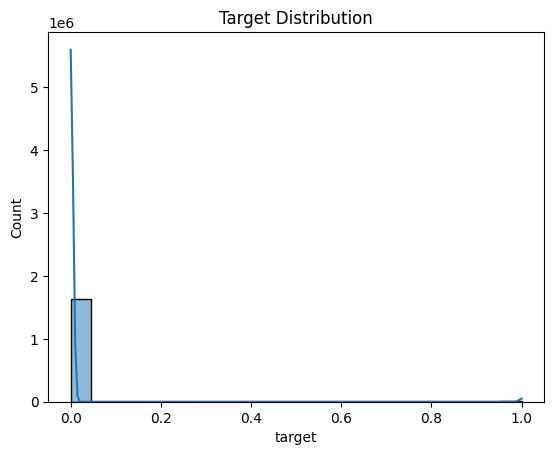

In [4]:
target_col = 'target'

sns.histplot(train[target_col], kde=True)
plt.title('Target Distribution')
plt.show()


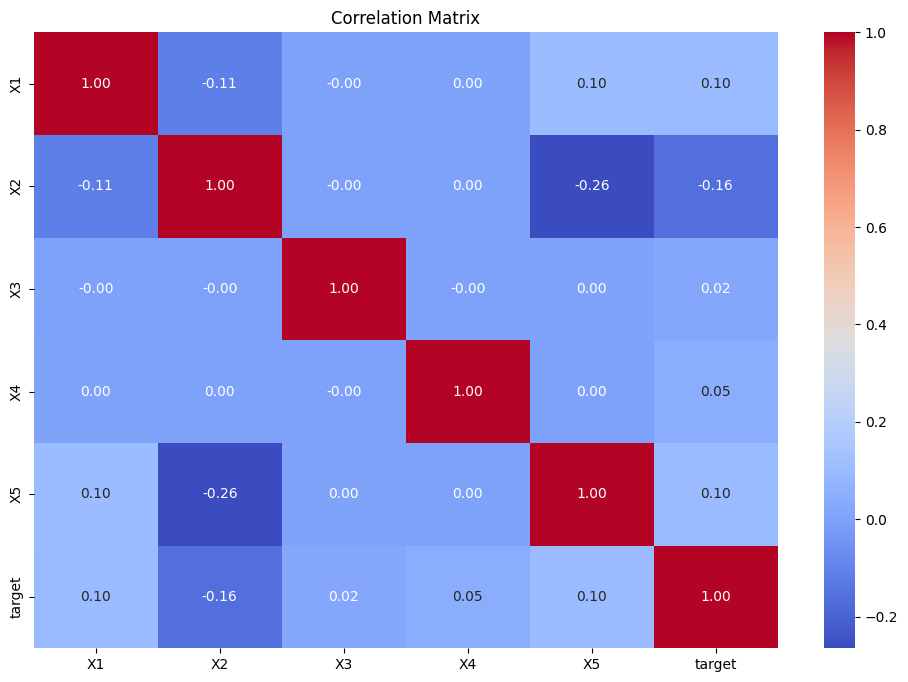

In [5]:
corr = train.select_dtypes(include=np.number).corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


In [6]:
cat_cols = train.select_dtypes(include='object').columns
for col in cat_cols:
    print(f"\nColumn: {col}")
    print(train[col].value_counts().head(10))



Column: Date
Date
2022-02-28 00:00:00.000000000    2289
2023-05-21 00:00:00.000000000    1198
2023-07-27 00:00:00.000000000    1198
2024-08-04 00:00:00.000000000    1192
2021-07-16 00:00:00.000000000    1191
2024-11-08 00:00:00.000000000    1190
2022-01-21 00:00:00.000000000    1190
2023-11-14 00:00:00.000000000    1189
2021-05-18 00:00:00.000000000    1189
2024-04-09 00:00:00.000000000    1189
Name: count, dtype: int64


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

In [8]:
target_col = 'target'

In [9]:
X = train.drop(columns=[target_col])
y = train[target_col]


In [10]:
cat_cols = X.select_dtypes(include='object').columns

label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le


In [11]:
numeric_cols = X.select_dtypes(include=np.number).columns
imputer = SimpleImputer(strategy='mean')
X[numeric_cols] = imputer.fit_transform(X[numeric_cols])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=36)

In [25]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report

model = LGBMClassifier(n_estimators=1000, learning_rate=0.05)
model.fit(X_train, y_train,
          eval_set=[(X_val, y_val)])


[LightGBM] [Info] Number of positive: 11271, number of negative: 1300268
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.206217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 947
[LightGBM] [Info] Number of data points in the train set: 1311539, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008594 -> initscore=-4.748093
[LightGBM] [Info] Start training from score -4.748093


LGBMClassifier(learning_rate=0.05, n_estimators=1000)

In [27]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

val_preds = model.predict(X_val)

acc = accuracy_score(y_val, val_preds)
print(f"Accuracy: {acc:.4f}")

f1 = f1_score(y_val, val_preds, average='binary')
print(f" F1 Score: {f1:.4f}")

print("\n Confusion Matrix:")
print(confusion_matrix(y_val, val_preds))


Accuracy: 0.9954
 F1 Score: 0.6825

 Confusion Matrix:
[[324769    349]
 [  1153   1614]]


In [28]:
test = pd.read_csv('/content/test.csv')

test_ids = test['ID']

for col in cat_cols:
    if col in test.columns:
        le = label_encoders[col]
        test[col] = le.transform(test[col].astype(str))

test[numeric_cols] = imputer.transform(test[numeric_cols])


In [30]:
print("Train columns:", list(X.columns))
print("Test columns:", list(test.columns))


Train columns: ['Date', 'X1', 'X2', 'X3', 'X4', 'X5']
Test columns: ['ID', 'Date', 'X1', 'X2', 'X3', 'X4', 'X5']


In [31]:
test_ids = test['ID']

test = test.drop(columns=['ID'])

test = test[X.columns]

test_preds = model.predict(test)


In [32]:
submission = pd.DataFrame({
    'ID': test_ids,
    'target': test_preds
})

# Saveing  CSV
submission.to_csv('submission.csv', index=False)
print("✅ submission.csv created successfully!")


✅ submission.csv created successfully!


In [33]:
df = pd.read_csv("/content/submission.csv")

In [39]:
df.tail(10)

,ID,target
409846,409846,0
409847,409847,0
409848,409848,0
409849,409849,0
409850,409850,0
409851,409851,0
409852,409852,0
409853,409853,0
409854,409854,0
409855,409855,0


#Deep learning model

In [42]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [44]:
train['Date'] = pd.to_datetime(train['Date'])

train['hour'] = train['Date'].dt.hour
train['day'] = train['Date'].dt.day
train['weekday'] = train['Date'].dt.weekday
train['month'] = train['Date'].dt.month

In [45]:
X = train.drop(columns=['target',"Date"])
y = train['target']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [49]:
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=5,
                    batch_size=64,
                    verbose=1)


Epoch 1/5
20493/20493 ━━━━━━━━━━━━━━━━━━━━ 63s 3ms/step - accuracy: 0.9925 - loss: 0.0292 - val_accuracy: 0.9926 - val_loss: 0.0270
Epoch 2/5
20493/20493 ━━━━━━━━━━━━━━━━━━━━ 57s 3ms/step - accuracy: 0.9924 - loss: 0.0285 - val_accuracy: 0.9928 - val_loss: 0.0267
Epoch 3/5
20493/20493 ━━━━━━━━━━━━━━━━━━━━ 80s 3ms/step - accuracy: 0.9926 - loss: 0.0282 - val_accuracy: 0.9927 - val_loss: 0.0269
Epoch 4/5
20493/20493 ━━━━━━━━━━━━━━━━━━━━ 57s 3ms/step - accuracy: 0.9927 - loss: 0.0278 - val_accuracy: 0.9927 - val_loss: 0.0266
Epoch 5/5
20493/20493 ━━━━━━━━━━━━━━━━━━━━ 67s 3ms/step - accuracy: 0.9927 - loss: 0.0277 - val_accuracy: 0.9927 - val_loss: 0.0269


In [50]:
val_preds_proba = model.predict(X_val).flatten()

val_preds = (val_preds_proba > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_val, val_preds))
print("F1 Score:", f1_score(y_val, val_preds))
print("\nClassification Report:")
print(classification_report(y_val, val_preds))


10247/10247 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
Accuracy: 0.9927078091403998
F1 Score: 0.25397815912636507

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    325118
           1       0.93      0.15      0.25      2767

    accuracy                           0.99    327885
   macro avg       0.96      0.57      0.63    327885
weighted avg       0.99      0.99      0.99    327885



In [52]:
test = pd.read_csv('/content/test.csv')
test_ids = test['ID']
test = test.drop(columns=['ID'])


test['Date'] = pd.to_datetime(test['Date'])
test['hour'] = test['Date'].dt.hour
test['day'] = test['Date'].dt.day
test['weekday'] = test['Date'].dt.weekday
test['month'] = test['Date'].dt.month

test = test.drop(columns=['Date'])


test_scaled = scaler.transform(test)

test_preds = model.predict(test_scaled).flatten()
test_preds = (test_preds > 0.5).astype(int)


12808/12808 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step


In [53]:
submission = pd.DataFrame({
    "ID": test_ids,
    "target": test_preds
})
submission.to_csv("submission_Deep_Learning.csv", index=False, quoting=1)


In [54]:
df1 = pd.read_csv("/content/submission_Deep_Learning.csv")

In [55]:
df1.head()

,ID,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
